# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [2,3,4,9,5,6,7,12,1,0,8,15,16,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Wrist','L Hip','Chest','Head','Pelvis','Right Eye','Left Eye','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 3
right_wrist = 4

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["body_25/high/skeletons/", "body_25/medium/skeletons/", "body_25/mild/skeletons/", "body_25/low/skeletons/"]
threats = [0,1,2,2]


#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(974, 14, 3)
(974,)
[[-0.19211676 -1.03471354  0.64964402]
 [ 0.          0.          0.81176996]
 [ 0.4143182   0.91013209  0.77478099]
 [-0.96485562  0.5379595   0.39770767]
 [ 0.35900436 -1.04828018  0.62941569]
 [ 0.37315739 -0.27657718  0.56949055]
 [ 1.00827449 -0.48247441  0.80475724]
 [-0.44058157  0.55179644  0.34119952]
 [ 0.09696757 -1.0350196   0.71582872]
 [ 0.55235653 -1.64172453  0.87150502]
 [-0.68928617  0.53802326  0.37004882]
 [ 0.38692442 -1.73822584  0.82929856]
 [ 0.59393613 -1.73834482  0.82935184]
 [-0.95738372  0.75766429  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=4)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 13
0.02483987808227539
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.08163265306123%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.42857142857143%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 76.53061224489795%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 79.59183673469387%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 80.61224489795919%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy:

number of batches for training: 13
0.017069339752197266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.608247422680414%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 59.79381443298969%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.855670103092784%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 69.0721649484536%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 77.31958762886599%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 79.38144329896907%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 80.41237113402062%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.41237113402062. Mode

[[254.  23.  17.]
 [ 41.  85. 105.]
 [ 26.   8. 415.]]
mean
[[25.4  2.3  1.7]
 [ 4.1  8.5 10.5]
 [ 2.6  0.8 41.5]]
std
[[3.26190129 1.00498756 1.00498756]
 [1.81383571 2.57875939 3.07408523]
 [1.2        0.9797959  3.1701735 ]]
77.41273100616016
0.53683435163866
5.228766584960549


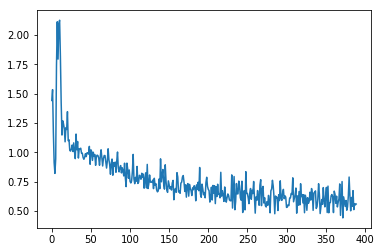

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  Low
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 25.4 & 2.3 & 1.7 & 29.4 \\
 & Med & 4.1 & 8.5 & 10.5 & 23.1 \\
 & Low & 2.6 & 0.8 & 41.5 & 44.9 \\
\toprule
 & Totals & 32.1 & 11.6 & 53.7 & 97.4


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 13
0.017955541610717773
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.204081632653065%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.42857142857143%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 76.53061224489795%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 78.57142857142857%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 80.61224489795919%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 81.63265306122449%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 82.6530612244898%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 83.6734693877551%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/b

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.25773195876289. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.025063276290893555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 68.04123711340206%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 69.0721649484536%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 72.16494845360825%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 73.19587628865979%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 75.25773195876289%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 79.38144329896907%
epoch

epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 78.35051546391753%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 81.44329896907216%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 82.4742268041237%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 85.56701030927834%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 87.62886597938144%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.62886597938144. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.01656365394592285
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.73195876288659%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7

number of batches for training: 13
0.019651174545288086
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.73195876288659%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 61.855670103092784%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 62.88659793814433%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 67.0103092783505%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 71.1340206185567%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 74.22680412371135%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 78.35051546391753%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model 

number of batches for training: 13
0.016687393188476562
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 66.3265306122449%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 72.44897959183673%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 78.57142857142857%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.57142857142857. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/b

epoch 14
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 84.6938775510204%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.6938775510204. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.022113561630249023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 50.0%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.36734693877551%
epoch 11
epoch 12
epoch 13
epo

number of batches for training: 13
0.01710987091064453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 44.329896907216494%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 48.45360824742268%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 59.79381443298969%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 71.1340206185567%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 73.19587628865979%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.28865979381443%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.28865979381443. Model 

number of batches for training: 13
0.017123937606811523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.824742268041234%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 62.88659793814433%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 75.25773195876289%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 77.31958762886599%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.38144329896907%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 80.41237113402062%
epoch 26
epoch 27
epoch 28
epoch 29
epoch

epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 76.28865979381443%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 77.31958762886599%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 78.35051546391753%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.01673102378845215
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.98969072164948%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 48.45360824742268%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 54.63917525773196%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 59.79381443298969%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.91752577319587%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.53061224489795%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.017223596572875977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.670103092783506%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 62.88659793814433%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 72.16494845360825%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 74.22680412371135%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.25773195876289%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Bes

number of batches for training: 13
0.016875267028808594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.0%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 65.3061224489796%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.36734693877551%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 72.44897959183673%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 73.46938775510205%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.46938775510205. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.016758203506469727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.69387755102041%
e

epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.42857142857143%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 72.44897959183673%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 75.51020408163265%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 79.59183673469387%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 80.61224489795919%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 82.6530612244898%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 83.6734693877551%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 84.6938775510204%
epoch 30
Traning ends. The best valid accuracy is 84.6938775510204. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_m

number of batches for training: 13
0.01696014404296875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.670103092783506%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.10309278350515%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 71.1340206185567%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.1340206185567. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.016803979873657227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.8041

number of batches for training: 13
0.017034530639648438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.927835051546392%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 56.70103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 64.94845360824742%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.1340206185567%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 72.16494845360825%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 80.41237113402062%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 81.44329896907216%
epoch 25
epoch 26
epoch 27
Best validation accurac

number of batches for training: 13
0.016702890396118164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.02061855670103%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 54.63917525773196%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.824742268041234%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.0721649484536%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 71.1340206185567%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 73.19587628865979%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 74.22680412371135%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 76.28865979381443%
epoch 

epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 69.38775510204081. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.01719522476196289
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 58.16326530612245%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.40816326530613%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 72.44897959183673%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 17
epoch 18

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 66.3265306122449%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 67.3469387755102%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 67.3469387755102. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 13
0.01733112335205078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.04081632653062%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.204081632653065%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 63.26530612244898%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 65.3061224489796%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best v

In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[257.  24.  13.]
 [ 39.  92. 100.]
 [ 24.  11. 414.]]
R Elbow
[[255.  25.  14.]
 [ 32.  92. 107.]
 [ 29.   9. 411.]]
R Wrist
[[254.  25.  15.]
 [ 38.  86. 107.]
 [ 25.  12. 412.]]
R Hip
[[246.  25.  23.]
 [ 37.  92. 102.]
 [ 24.  12. 413.]]
L Shoulder
[[255.  26.  13.]
 [ 33.  95. 103.]
 [ 31.  10. 408.]]
L Elbow
[[250.  31.  13.]
 [ 31.  97. 103.]
 [ 29.  11. 409.]]
L Wrist
[[256.  25.  13.]
 [ 33.  98. 100.]
 [ 27.  10. 412.]]
L Hip
[[251.  24.  19.]
 [ 31.  90. 110.]
 [ 25.  14. 410.]]
Chest
[[253.  24.  17.]
 [ 30.  96. 105.]
 [ 28.   7. 414.]]
Head
[[256.  23.  15.]
 [ 35.  95. 101.]
 [ 31.  15. 403.]]
Pelvis
[[255.  23.  16.]
 [ 27. 100. 104.]
 [ 30.  12. 407.]]
Right Eye
[[249.  29.  16.]
 [ 41.  86. 104.]
 [ 28.  13. 408.]]
Left Eye
[[254.  23.  17.]
 [ 36.  95. 100.]
 [ 29.  13. 407.]]
Gun
[[244.  17.  33.]
 [ 34.  70. 127.]
 [ 36.  22. 391.]]
mean
[[[29.21428571  1.71428571  1.07142857]
  [ 3.          7.          8.        ]
  [ 2.14285714  0.71428571 45.14285714

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
78.33675564681725
R Elbow
77.82340862422998
R Wrist
77.20739219712526
R Hip
77.1047227926078
L Shoulder
77.82340862422998
L Elbow
77.61806981519507
L Wrist
78.64476386036962
L Hip
77.1047227926078
Chest
78.33675564681725
Head
77.41273100616016
Pelvis
78.2340862422998
Right Eye
76.28336755646818
Left Eye
77.61806981519507
Gun
72.38193018480493
1
83.22539883114831
0.16795862607846512


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 13
0.017414331436157227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.91836734693878%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.26530612244898%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 76.53061224489795%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 82.6530612244898%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.6530612244898. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016718626022338867
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 60.204081632653065%
epoch 7
epoch 8
Best validation accura

epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 72.16494845360825%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017323970794677734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.329896907216494%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 49.48453608247423%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 57.73195876288659%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 61.855670103092784%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iterat

epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 80.41237113402062%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 81.44329896907216%
epoch 25
Best validation accuracy! iteration:325 accuracy: 83.50515463917526%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.50515463917526. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016972780227661133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.608247422680414%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 58.76288659793815%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.1340206185567%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation acc

number of batches for training: 13
0.017015457153320312
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.79381443298969%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 64.94845360824742%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 71.1340206185567%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 72.16494845360825%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 77.31958762886599%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 78.35051546391753%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01683831214904785
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.927835051546392%


number of batches for training: 13
0.0171053409576416
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.804123711340207%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 47.42268041237113%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.16494845360825%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 76.28865979381443%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 78.35051546391753%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 79.38144329896907%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model 

number of batches for training: 13
0.02257537841796875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.591836734693878%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.16326530612245%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 62.244897959183675%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 65.3061224489796%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 68.36734693877551%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 69.38775510204081%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.42857142857143. Model named model.
INFO:tensorflow:Restoring parameters from model/model


number of batches for training: 13
0.016600608825683594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 43.87755102040816%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 47.95918367346938%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 48.97959183673469%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 53.06122448979592%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 59.183673469387756%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 64.28571428571429%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 65.3061224489796%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 66.3265306122449%
epoch 25
Best validation accuracy! iteration:325 accuracy: 69.38775510204081%
epoch 26
epoch 27
epoch 28
epoch 29
Best 

epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 72.16494845360825%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016678333282470703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 46.391752577319586%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 47.42268041237113%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 50.51546391752577%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 51.546391752577314%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 62.88659793814433%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 69.0721649484536%
epoch 17
epoch 18
Best val

epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 82.4742268041237%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 83.50515463917526%
epoch 30
Traning ends. The best valid accuracy is 83.50515463917526. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017100095748901367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.329896907216494%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.855670103092784%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 71.1340206185567%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation acc

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.19587628865979%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 74.22680412371135%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.25773195876289%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 76.28865979381443%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 77.31958762886599%
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016736268997192383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 61.855670103092784%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.

epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 69.38775510204081%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 70.40816326530613%
epoch 25
Best validation accuracy! iteration:325 accuracy: 71.42857142857143%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 74.48979591836735%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.48979591836735. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.0205385684967041
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 62.88659793814433%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 72.16494845360825%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 73.19587628865979%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 76.28865979381443%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iter

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 70.40816326530613%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 72.44897959183673%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 74.48979591836735%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 76.53061224489795%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.53061224489795. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016605138778686523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 65.3061224489796%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 67.3469387755102%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.40816326530613%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 11
epoch 12
Best validation accur

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 73.19587628865979%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 75.25773195876289%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 76.28865979381443%
epoch 25
Best validation accuracy! iteration:325 accuracy: 77.31958762886599%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017201900482177734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 61.224489795918366%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 69.38775510204081%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 76.53061224489795%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 82.6530612244898%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 84.69

epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 73.19587628865979%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 74.22680412371135%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.22680412371135. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017571449279785156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.546391752577314%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 64.94845360824742%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 67.0103092783505%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.0721649484536%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 70.10309278350515%
epoch 15
epoch 16
Best valid

number of batches for training: 13
0.01694941520690918
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.896907216494846%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.70103092783505%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 67.0103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.1340206185567%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 72.16494845360825%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 74.22680412371135%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 76.28865979381443%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 77.31958762886599%
epoch 3

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.38144329896907%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 80.41237113402062%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.41237113402062. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.0175631046295166
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 48.45360824742268%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.855670103092784%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 78.35051546391753%
epoch 13
epoch 14
epo

number of batches for training: 13
0.016999006271362305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.51546391752577%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 62.88659793814433%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.0721649484536%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 71.1340206185567%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 73.19587628865979%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.19587628865979. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016780614852905273
epoch 1
epoch 2


number of batches for training: 13
0.016607284545898438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 66.3265306122449%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.36734693877551%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 70.40816326530613%
epoch 25
Best validation accuracy! iteration:325 accuracy: 71.42857142857143%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.42857142857143. Model

epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 82.6530612244898%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01903057098388672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.95918367346938%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.16326530612245%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.48979591836735%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 15
epoch 16
epoch 17
epoch

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 72.16494845360825%
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01792597770690918
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 68.04123711340206%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.1340206185567%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 73.19587628865979%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 76.28865979381443%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 77.31958762886599%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 78.35051546391753%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28


number of batches for training: 13
0.016644954681396484
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.02061855670103%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.855670103092784%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 76.28865979381443%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 81.44329896907216%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 82.4742268041237%
epoch 30
Traning ends. The best valid accuracy is 82.4742268041237. Model 

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 75.25773195876289%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 76.28865979381443%
epoch 30
Traning ends. The best valid accuracy is 76.28865979381443. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.024272918701171875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.896907216494846%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.0721649484536%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.10309278350515%
epoch 13
epoch 14
B

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 72.44897959183673%
epoch 30
Traning ends. The best valid accuracy is 72.44897959183673. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01689457893371582
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 63.91752577319587%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 68.04123711340206%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 75.25773195876289%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epo

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 74.48979591836735%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.48979591836735. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016776561737060547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 65.3061224489796%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.36734693877551%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 70.

epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 76.28865979381443%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.31958762886599%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016916751861572266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.10204081632652%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 66.3265306122449%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.48979591836735%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 81.63265306122449%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 83.6734693877551%
ep

number of batches for training: 13
0.016619443893432617
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.45360824742268%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.608247422680414%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.79381443298969%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.0103092783505%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 70.10309278350515%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.10309278350515. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017127513885498047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 65.97938144329896%

epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 68.04123711340206%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 74.22680412371135%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 76.28865979381443%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 77.31958762886599%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 78.35051546391753%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 82.4742268041237%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.4742268041237. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016583681106567383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.670103092783506%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 61.855670103092784%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 78.35051546391753%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 79.38144329896907%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016702651977539062
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.23711340206185%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.79381443298969%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.10309278350515%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 72.16494845360825%


epoch 18
Best validation accuracy! iteration:225 accuracy: 72.44897959183673%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 74.48979591836735%
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.51020408163265%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.55102040816327%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017168521881103516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.773195876288657%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.134020618

number of batches for training: 13
0.01674199104309082
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.46938775510204%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 62.244897959183675%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.28571428571429%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 65.3061224489796%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 66.3265306122449%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 67.3469387755102%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 69.38775510204081%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 72.44897959183673%
epoch 3

number of batches for training: 13
0.016739845275878906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.546391752577314%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.76288659793815%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 68.04123711340206%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 74.22680412371135%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 80.41237113402062%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.41237113402062. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01695084571838379
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.14285714285714%

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 74.22680412371135%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 75.25773195876289%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.31958762886599%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 78.35051546391753%
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017195463180541992
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 10.309278350515463%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 27.835051546391753%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 53.608247422680414%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 62.88659793814433%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation 

number of batches for training: 13
0.018055200576782227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.45360824742268%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 67.0103092783505%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 69.0721649484536%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 71.1340206185567%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 72.16494845360825%
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016936540603637695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.48453608247423%
e

epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.38144329896907%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016819000244140625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 62.88659793814433%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 68.04123711340206%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 69.0721649484536%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.25773195876289%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 76.28865979381443%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 2

epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 69.38775510204081%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 70.40816326530613%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 71.42857142857143%
epoch 30
Traning ends. The best valid accuracy is 71.42857142857143. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.019706010818481445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.36082474226804%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 56.70103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.824742268041234%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 64.94845360824742%
epoch 11
epoch 12
Best validation accuracy! iteration:

epoch 18
Best validation accuracy! iteration:225 accuracy: 73.46938775510205%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 74.48979591836735%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.48979591836735. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016849994659423828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.95918367346938%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.10204081632652%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.40816326530613%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 72.44897959183673%
epoch 17
e

number of batches for training: 13
0.016990184783935547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.12244897959183%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 76.53061224489795%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 77.55102040816327%
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model


epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 82.6530612244898%
epoch 25
Best validation accuracy! iteration:325 accuracy: 83.6734693877551%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016571998596191406
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 66.3265306122449%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.36734693877551%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.44897959183673%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 15
epoch 16
Bes

number of batches for training: 13
0.016796112060546875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.20618556701031%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 55.670103092783506%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 68.04123711340206%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 71.1340206185567%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 72.16494845360825%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.023573637008666992
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.57142857142857%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.

number of batches for training: 13
0.01694512367248535
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.23711340206185%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.824742268041234%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 77.31958762886599%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 79.38144329896907%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 81.44329896907216%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01762986183166504
epoch 1
epoch 2

epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 74.22680412371135%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.25773195876289%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.31958762886599%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.02292156219482422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.2680412371134%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.824742268041234%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.0721649484536%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iter

epoch 16
Best validation accuracy! iteration:200 accuracy: 71.1340206185567%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 73.19587628865979%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 76.28865979381443%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.28865979381443. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.0168759822845459
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.546391752577314%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 61.855670103092784%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 72.16494845360825%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
ep

Best validation accuracy! iteration:250 accuracy: 72.44897959183673%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.44897959183673. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.023490190505981445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.26530612244898%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.36734693877551%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 72.44897959183673%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 76.53061224489795%
epoch 17
epoch 18
Best validation acc

epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 80.61224489795919%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016649961471557617
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.46938775510204%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 35.714285714285715%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 74.48979591836735%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 69.0721649484536%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 72.16494845360825%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 77.31958762886599%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016671180725097656
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.0%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.204081632653065%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 71.42857142857143%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 78.57142857142857%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best valida

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.02078104019165039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.70103092783505%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.0721649484536%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 70.10309278350515%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 71.1340206185567%
epoch 28
e

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 69.0721649484536%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 69.0721649484536. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01788163185119629
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 65.97938144329896%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 67.0103092783505%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 68.04123711340206%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 69.0721649484536%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 70.10309278350515%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 73.19587628865979%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 75.25773195876289%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 76.28865979381443%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.31958762886599%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016762495040893555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 62.88659793814433%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.10309278350515%
epoch 9
epoch 10
Best validation accuracy! iteration:1

number of batches for training: 13
0.016805648803710938
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 43.87755102040816%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 47.95918367346938%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 52.04081632653062%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 56.12244897959183%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.28571428571429%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 66.3265306122449%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 67.3469387755102%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 68.36734693877551%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 71.42857142857143%
epoch 28
epoch 29
epoch

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 76.53061224489795%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016675472259521484
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 66.3265306122449%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.44897959183673%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
ep

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.28865979381443%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 78.35051546391753%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 79.38144329896907%
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016551494598388672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 22.448979591836736%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 40.816326530612244%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 60.204081632653065%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 62.244897959183675%
epoch 9
epoch 10
Best validation accuracy! iterati

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 74.22680412371135%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.25773195876289%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.25773195876289. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01701045036315918
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.79381443298969%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 74.22680412371135%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24


number of batches for training: 13
0.016883134841918945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.958762886597935%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 49.48453608247423%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 52.57731958762887%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 56.70103092783505%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.0721649484536%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 80.41237113402062%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 81.44329896907216%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model

Best validation accuracy! iteration:250 accuracy: 78.35051546391753%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016614675521850586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.608247422680414%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.855670103092784%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.0103092783505%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 68.04123711340206%
epoch 19
epoch 20


epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 73.46938775510205%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 74.48979591836735%
epoch 30
Traning ends. The best valid accuracy is 74.48979591836735. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016700029373168945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.36734693877551%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 74.48979591836735%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation a

epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 72.44897959183673%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 73.46938775510205%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 75.51020408163265%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017030954360961914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.04081632653062%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.3469387755102%
epoch 13
epoch 14
epoch 15
epoch 16
epo

number of batches for training: 13
0.017403364181518555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.63917525773196%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.70103092783505%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.10309278350515%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 73.19587628865979%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.25773195876289%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 76.28865979381443%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 77.31958762886599%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

number of batches for training: 13
0.016978025436401367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.2680412371134%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.608247422680414%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 64.94845360824742%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 67.0103092783505%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.10309278350515%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 71.1340206185567%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 72.16494845360825%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 74.22680412371135%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.22680412371135. Model n

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 77.31958762886599%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.38144329896907%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 80.41237113402062%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 81.44329896907216%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01683831214904785
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.11340206185567%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 47.42268041237113%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 56.70103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.76288659793815%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 61.855

number of batches for training: 13
0.016625165939331055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.896907216494846%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 47.42268041237113%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.76288659793815%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 61.855670103092784%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 65.97938144329896%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 67.0103092783505%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 71.1340206185567%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.1340206185567. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 73.46938775510205%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.46938775510205. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01705145835876465
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.608247422680414%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 58.76288659793815%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.10309278350515%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 76.28865979381443%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 79.38144329896907%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 2

number of batches for training: 13
0.01671004295349121
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.10204081632652%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.204081632653065%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 64.28571428571429%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 65.3061224489796%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 67.3469387755102%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 68.36734693877551%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 69.38775510204081%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 70.40816326530613%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 71.42857142857143%
epoch 

epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 81.63265306122449%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 82.6530612244898%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016762971878051758
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.204081632653065%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 67.3469387755102%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 72.44897959183673%
epoch 17
epoch 18
epoc

number of batches for training: 13
0.019663333892822266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.63917525773196%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.824742268041234%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.10309278350515%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 72.16494845360825%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 73.19587628865979%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 74.22680412371135%
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.25773195876289%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 77.31958762886599%
epo

number of batches for training: 13
0.016571521759033203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.36082474226804%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 54.63917525773196%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.76288659793815%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 61.855670103092784%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 64.94845360824742%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 80.41237113402062%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 81.44329896907216%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Mod

epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 75.25773195876289%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 76.28865979381443%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.31958762886599%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01766514778137207
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.48453608247423%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 51.546391752577314%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 67.0103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 72.16494845360825%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 75.25773195876289%
epoch 11
epoch 12
Best validation accuracy! iteration:15

epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016556501388549805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.11340206185567%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 70.10309278350515%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 74

number of batches for training: 13
0.019952774047851562
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.12244897959183%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.204081632653065%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 64.28571428571429%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.3469387755102%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 68.36734693877551%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 69.38775510204081%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 70.40816326530613%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 71.42857142857143%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 

epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 83.6734693877551%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017716407775878906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 70.40816326530613%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 72.44897959183673%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 74.48979591836735%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 2

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016874074935913086
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.83673469387755%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.42857142857143%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 74.48979591836735%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 76.53061224489795%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 78.57142857142857%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 81.63265306122449%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 82.6530612244898%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24

epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.19587628865979%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 74.22680412371135%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.22680412371135. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01658034324645996
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.23711340206185%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.79381443298969%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.855670103092784%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 67.0103092783505%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.

epoch 14
Best validation accuracy! iteration:175 accuracy: 72.16494845360825%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 74.22680412371135%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.22680412371135. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01663517951965332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.2680412371134%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.824742268041234%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 62.88659793814433%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accu

number of batches for training: 13
0.017328739166259766
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 61.855670103092784%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 69.0721649484536%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 76.28865979381443%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 79.38144329896907%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.02119278907775879
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.02061855670103%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.9

number of batches for training: 13
0.016675710678100586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.23711340206185%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 42.2680412371134%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 44.329896907216494%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 47.42268041237113%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 53.608247422680414%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 60.824742268041234%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 61.855670103092784%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.94845360824742%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.10309278350515%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 73.19587628865979%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accurac

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 74.48979591836735%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 75.51020408163265%
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016840696334838867
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 64.94845360824742%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 73.19587628865979%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 79.38144329896907%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 

epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 72.44897959183673%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 73.46938775510205%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 74.48979591836735%
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 75.51020408163265%
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01688075065612793
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.83673469387755%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 64.28571428571429%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoc

number of batches for training: 13
0.018354177474975586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.6734693877551%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.16326530612245%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 60.204081632653065%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 62.244897959183675%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.26530612244898%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 66.3265306122449%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 70.40816326530613%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 71.42857142857143%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 72.44897959183673%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.44897959183673. Model

number of batches for training: 13
0.01668405532836914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 61.855670103092784%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 67.0103092783505%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 70.10309278350515%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.19587628865979%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 77.31958762886599%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 81.44329896907216%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01671457290649414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.608247422680414%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 55.670103092783506%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 65.97938144329896%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 67.0103092783505%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.0721649484536%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 

number of batches for training: 13
0.0169222354888916
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.63917525773196%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 62.88659793814433%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 64.94845360824742%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 79.38144329896907%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 81.44329896907216%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
num

number of batches for training: 13
0.016774654388427734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 58.76288659793815%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 64.94845360824742%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 67.0103092783505%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 69.0721649484536%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.16494845360825%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 76.28865979381443%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 77.31958762886599%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
num

epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 68.36734693877551%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 68.36734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01976752281188965
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.12244897959183%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.204081632653065%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 66.3265306122449%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.38775510204081%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.40816326530613%
epoch 19
epoch 20
epo

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 82.6530612244898%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.6530612244898. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01685810089111328
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.55102040816326%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 54.08163265306123%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.3469387755102%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 71.428

number of batches for training: 13
0.016780614852905273
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.98969072164948%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 63.91752577319587%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.10309278350515%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.16494845360825%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.28865979381443%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.28865979381443. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

number of batches for training: 13
0.017039775848388672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.546391752577314%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 67.0103092783505%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 69.0721649484536%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 70.10309278350515%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 71.1340206185567%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 72.16494845360825%
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016944169998168945
epoch 1
epoch 2

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 85.56701030927834%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.56701030927834. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016802072525024414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.2680412371134%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 52.57731958762887%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.824742268041234%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.91752577319587%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 71.1340206185567%
epoch 15
epoch 16
B

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 78.35051546391753%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 79.38144329896907%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017346858978271484
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 46.391752577319586%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 51.546391752577314%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 60.824742268041234%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 67.0103092783505%
epoch 13
epoch 14
Best validation a

epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017052412033081055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 53.608247422680414%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 59.79381443298969%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.0721649484536%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 73.19587628865979%
epoch 26
epoch 

number of batches for training: 13
0.017086505889892578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.10204081632652%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 62.244897959183675%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.28571428571429%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 66.3265306122449%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 72.44897959183673%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.44897959183673. Model named model.
INFO:tensorflow:Restoring parameters from model/model
nu

number of batches for training: 13
0.017004966735839844
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.12244897959183%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.40816326530613%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.48979591836735%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.53061224489795%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 79.59183673469387%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model


number of batches for training: 13
0.01663494110107422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.95918367346938%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.10204081632652%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 70.40816326530613%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 78.57142857142857%
epoch 25
epoch 26
epoch 27
Best validation accuracy!

epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 69.0721649484536. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01723456382751465
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 52.57731958762887%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 60.824742268041234%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.855670103092784%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.0721649484536%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.10309278350515%
epoch 19
ep

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 79.38144329896907%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016775846481323242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.927835051546392%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 65.97938144329896%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 69.0721649484536%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 70.10309278350515%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accur

epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.50515463917526. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017097949981689453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.175257731958766%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.70103092783505%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 73.19587628865979%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 75.25773195876289%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 78.35051546391753%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 80.41237113402062%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 

number of batches for training: 13
0.016710758209228516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.29896907216495%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.76288659793815%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.94845360824742%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 74.22680412371135%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 75.25773195876289%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 77.31958762886599%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 78.35051546391753%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 

number of batches for training: 13
0.01690840721130371
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 52.04081632653062%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.10204081632652%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.16326530612245%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 66.3265306122449%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 72.44897959183673%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 74.48979591836735%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.48979591836735. Model named model.
INFO:tensorflow:Restoring parameters from model/model
nu

number of batches for training: 13
0.017388343811035156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.12244897959183%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 64.28571428571429%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 70.40816326530613%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.44897959183673%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.53061224489795%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 77.55102040816327%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model


epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 77.31958762886599%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 78.35051546391753%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016959190368652344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 66.3265306122449%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 71.42857142857143%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 74.48979591836735%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 77.55102040816327%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 78.57142857142857%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 81.63265306122449%
epoch 13
epoch 14
Be

epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 67.0103092783505%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 68.04123711340206%
epoch 30
Traning ends. The best valid accuracy is 68.04123711340206. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017932415008544922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.896907216494846%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 36.08247422680412%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 52.57731958762887%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.824742268041234%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 61.855670103092784%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best val

number of batches for training: 13
0.016837358474731445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 51.546391752577314%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 58.76288659793815%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.855670103092784%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.91752577319587%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 68.04123711340206%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 69.0721649484536%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.10309278350515%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 71.1340206185567%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 72.16494845360825%
epoch 26
epoch 27
epoch 28
epoch 29
epoch

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 72.16494845360825%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 73.19587628865979%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 74.22680412371135%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 77.31958762886599%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.31958762886599. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016623735427856445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.57731958762887%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 74.22680412371135%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 80.41237113402062%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 81.44329896907216%
epoch 15
epoch 16


epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.44329896907216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01687312126159668
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.42268041237113%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.91752577319587%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 75.25773195876289%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 76.28865979381443%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 79.38144329896907%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 

number of batches for training: 13
0.016468286514282227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 52.04081632653062%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 66.3265306122449%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 67.3469387755102%
epoch 25
Best validation accuracy! iteration:325 accuracy: 69.38775510204081%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 69.38775510204081. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016577959060668945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 64.94845360824742%


epoch 18
Best validation accuracy! iteration:225 accuracy: 72.44897959183673%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 74.48979591836735%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 76.53061224489795%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 78.57142857142857%
epoch 25
Best validation accuracy! iteration:325 accuracy: 79.59183673469387%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016914844512939453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.10204081632652%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 9
epoc

number of batches for training: 13
0.016988515853881836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 70.40816326530613%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 74.48979591836735%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 80.61224489795919%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016600847244262695
epoch 1
epoch

number of batches for training: 13
0.016855955123901367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.20618556701031%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 55.670103092783506%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.04123711340206%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 72.16494845360825%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 73.19587628865979%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 74.22680412371135%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 75.25773195876289%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 76.28865979381443%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 78.35051546391753%
epoch 28
epoch 29
epoc

Best validation accuracy! iteration:200 accuracy: 70.10309278350515%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 71.1340206185567%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 72.16494845360825%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.16494845360825. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01697850227355957
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.670103092783506%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.824742268041234%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 62.88659793814433%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 63.91752577319587%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.94845360824742%


number of batches for training: 13
0.016881942749023438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.670103092783506%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.76288659793815%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 65.97938144329896%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 72.16494845360825%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 78.35051546391753%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 80.41237113402062%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 83.50515463917526%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 84.5360824742268%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 85.56701030927834%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.56701030927834. Model

epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 77.31958762886599%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 78.35051546391753%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 79.38144329896907%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017059326171875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.773195876288657%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 45.36082474226804%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 51.546391752577314%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 60.824742268041234%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
epoch 13
e

epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.40816326530613%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.40816326530613. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016768932342529297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 54.08163265306123%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 76.53061224489795%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 82.6530612244898%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.6530612244898. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017460107803344727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 60.204081632653065%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 66.3265306122449%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 68.36734693877551%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 70.40816326530613%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 72.44897959183673%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 15
epoch 16
ep

number of batches for training: 13
0.016946792602539062
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 20.408163265306122%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 54.08163265306123%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 56.12244897959183%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 77.55102040816327%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 80.61224489795919%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.61224489795919. Model named model.
INFO:tensorflow:Restoring parameters from model/model


epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.10309278350515%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.10309278350515. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.019077777862548828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.927835051546392%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 49.48453608247423%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 52.57731958762887%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.76288659793815%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 59.79381443298969%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 61.855670103092784%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 67.0103092783505%


number of batches for training: 13
0.016729354858398438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.546391752577314%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 61.855670103092784%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 72.16494845360825%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 77.31958762886599%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 78.35051546391753%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 79.38144329896907%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016770124435424805
epoch 1
epoc

number of batches for training: 13
0.016566991806030273
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.20618556701031%
epoch 3
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 49.48453608247423%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 65.97938144329896%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 68.04123711340206%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 76.28865979381443%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 80.41237113402062%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 81.44329896907216%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 82.4742268041237%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.4742268041237. Model named model.
INFO:tensorflow:Restoring parameters from model/model
nu

epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 75.51020408163265%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.016725778579711914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.70103092783505%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 63.91752577319587%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 68.04123711340206%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 71.1340206185567%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 75.25773195876289%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
ep

epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 68.36734693877551%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 70.40816326530613%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 71.42857142857143%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.42857142857143. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.017119646072387695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.0%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 54.08163265306123%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.28571428571

number of batches for training: 13
0.01686882972717285
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.16326530612245%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 78.57142857142857%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 80.61224489795919%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 82.6530612244898%
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 83.6734693877551%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 84.6938775510204%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 85.71428571428571%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30


number of batches for training: 13
0.016875505447387695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.63917525773196%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 59.79381443298969%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 68.04123711340206%
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 74.22680412371135%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 75.25773195876289%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 76.28865979381443%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 77.31958762886599%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 79.38144329896907%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.38144329896907. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 81.44329896907216%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 83.50515463917526%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.50515463917526. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01711249351501465
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.391752577319586%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 57.73195876288659%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 58.76288659793815%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 60.824742268041234%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 62.88659793814433%
epoch 15
epoch 16
Best validation accuracy! iteration:200 accuracy: 64.94845360824742%


number of batches for training: 13
0.01667952537536621
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.824742268041234%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 64.94845360824742%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 65.97938144329896%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 68.04123711340206%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:225 accuracy: 70.10309278350515%
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 72.16494845360825%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 73.19587628865979%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 74.22680412371135%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.22680412371135. Model named model.
INFO:tensorflow:Restoring parameters from model/model


epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 74.48979591836735%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 76.53061224489795%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.53061224489795. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01656961441040039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.79381443298969%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 64.94845360824742%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 70.10309278350515%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 74.22680412371135%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 77.31958762886599%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 78.35051546391753%
epoch 15
epoch 16
ep

number of batches for training: 13
0.017006635665893555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 56.12244897959183%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:100 accuracy: 58.16326530612245%
epoch 9
epoch 10
Best validation accuracy! iteration:125 accuracy: 60.204081632653065%
epoch 11
epoch 12
Best validation accuracy! iteration:150 accuracy: 64.28571428571429%
epoch 13
epoch 14
Best validation accuracy! iteration:175 accuracy: 66.3265306122449%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 68.36734693877551%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 69.38775510204081%
epoch 25
Best validation accuracy! iteration:325 accuracy: 70.40816326530613%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.40816326530613. Mode

number of batches for training: 13
0.018011808395385742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 65.3061224489796%
epoch 5
epoch 6
Best validation accuracy! iteration:75 accuracy: 73.46938775510205%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:325 accuracy: 75.51020408163265%
epoch 26
epoch 27
Best validation accuracy! iteration:350 accuracy: 76.53061224489795%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.53061224489795. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 13
0.01717686653137207
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
epoch 4
Best validation accuracy! iteration:50 accuracy: 58.16

epoch 19
epoch 20
Best validation accuracy! iteration:250 accuracy: 76.28865979381443%
epoch 21
epoch 22
Best validation accuracy! iteration:275 accuracy: 77.31958762886599%
epoch 23
epoch 24
Best validation accuracy! iteration:300 accuracy: 78.35051546391753%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.35051546391753. Model named model.
INFO:tensorflow:Restoring parameters from model/model


In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
76.79671457905543
R Shoulder R Elbow
77.31006160164272
R Shoulder R Wrist
78.2340862422998
R Shoulder R Hip
77.72073921971253
R Shoulder L Shoulder
76.59137577002053
R Shoulder L Elbow
76.69404517453799
R Shoulder L Wrist
78.54209445585215
R Shoulder L Hip
78.2340862422998
R Shoulder Chest
76.48870636550308
R Shoulder Head
78.4394250513347
R Shoulder Pelvis
77.72073921971253
R Shoulder Right Eye
76.79671457905543
R Shoulder Left Eye
77.61806981519507
R Shoulder Gun
72.07392197125256
R Elbow R Elbow
76.79671457905543
R Elbow R Wrist
76.59137577002053
R Elbow R Hip
78.33675564681725
R Elbow L Shoulder
76.69404517453799
R Elbow L Elbow
77.61806981519507
R Elbow L Wrist
77.51540041067761
R Elbow L Hip
77.41273100616016
R Elbow Chest
78.13141683778234
R Elbow Head
77.61806981519507
R Elbow Pelvis
77.20739219712526
R Elbow Right Eye
78.33675564681725
R Elbow Left Eye
76.38603696098562
R Elbow Gun
72.79260780287474
R Wrist R Wrist
77.31006160164272
R Wrist R Hip
77.51540

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 76.8\% & 77.3\% & 78.2\% & 77.7\% & 76.6\% & 76.7\% & 78.5\% & 78.2\% & 76.5\% & 78.4\% & 77.7\% & 76.8\% & 77.6\% & 72.1 \% \\
R Elbow &       & 76.8\% & 76.6\% & 78.3\% & 76.7\% & 77.6\% & 77.5\% & 77.4\% & 78.1\% & 77.6\% & 77.2\% & 78.3\% & 76.4\% & 72.8 \% \\
R Wrist &       &       & 77.3\% & 77.5\% & 78.5\% & 76.7\% & 77.4\% & 78.7\% & 76.5\% & 78.7\% & 77.1\% & 76.6\% & 77.6\% & 69.6 \% \\
R Hip &       &       &       & 77.3\% & 77.9\% & 79.1\% & 77.5\% & 76.6\% & 77.2\% & 78.0\% & 77.0\% & 76.7\% & 78.1\% & 73.1 \% \\
L Shoulder &       &       &       &       & 77.1\% & 78.3\% & 78.7\% & 76.9\% & 77.8\% & 77.1\% & 78.0\% & 77.6\% & 76.3\% & 72.9 \% \\
L Elbow &       &       &       &       &       & 77.3\% & 77.6\% & 78.4\% & 78.3\% & 77.7\% & 77.1\% & 76.7\% & 77.2\% & 72.5 \% \\
L Wrist &       &       &       &       &       &       & 76.2\% & 76.0\% & 77.0\% & 77.1\% & 77.1\% & 77.3\% & 76.7\% & 72.0 \% \\
L Hip &       &       &       &       &       &    